In [33]:
from yaml import safe_load
from itertools import product
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import torch
import math

from fdiff.utils.fourier import spectral_density
from einops import rearrange

warnings.simplefilter("ignore", (UserWarning, FutureWarning))

In [34]:
def infer_dataset(datamodule: str) -> str:
    if "ECG" in datamodule:
        return "ECG"
    if "MIMICIII" in datamodule:
        return "MIMIC-III"
    if "NASDAQ" in datamodule:
        return "NASDAQ-2019"
    
def infer_diffusion_domain(fourier_transform: bool) -> str:
    if fourier_transform:
        return "Frequency"
    else:
        return "Time"    

def calculate_metrics(results: dict) -> list[dict]:
    data = []
    for domain, method in product({"time", "freq"}, {"sliced", "marginal"}):
            all_distances = results[f"{domain}_{method}_wasserstein_all"]           
            data.extend([{
                "Value": distance, 
                "Metric Domain": "Frequency" if domain == "freq" else "Time",
                "Metric": "Sliced Wasserstein" if method == "sliced" else "Marginal Wasserstein",
                          } for distance in all_distances])
    return data        

def calculate_spectral_density(marginal_distances: list[float], dataset_name: str) -> list[float]:
    match dataset_name:
        case "ECG":
            max_len = 187
        case "NASDAQ-2019":
            max_len = 252
        case "MIMIC-III":
            max_len = 24
        case _:
            raise ValueError("Dataset not recognized")
    marginals_tensor = torch.tensor(marginal_distances)
    marginals_tensor = rearrange(marginals_tensor, "(max_len n_channels) -> 1 max_len n_channels", max_len =max_len)
    
    # Extract real and imaginary parts
    n_real = math.ceil((max_len + 1) / 2)
    x_re = marginals_tensor[:, :n_real, :]
    x_im = marginals_tensor[:, n_real:, :]

    # Create imaginary tensor
    zero_padding = torch.zeros(size=(marginals_tensor.size(0), 1, marginals_tensor.size(2)))
    x_im = torch.cat((zero_padding, x_im), dim=1)

    # If number of time steps is even, put the null imaginary part
    if max_len % 2 == 0:
        x_im = torch.cat((x_im, zero_padding), dim=1)

    assert (
        x_im.size() == x_re.size()
    ), f"The real and imaginary parts should have the same shape, got {x_re.size()} and {x_im.size()} instead."

    return (x_re + x_im).mean(dim=2).flatten().tolist()
    

In [11]:
run_list = ["xxqse6xu", "na9xdfui", "c95j8zv7", "nzaxqmaz", "bf3lrfx9", "emk7nyz3"]
runs_dir = Path.cwd() / "../lightning_logs/"

In [13]:
df_list = []
for run in run_list:
    with open(runs_dir / f"{run}/train_config.yaml", "r") as f:
        config = safe_load(f)
        dataset = infer_dataset(config["datamodule"]["_target_"])
        domain = infer_diffusion_domain(config["fourier_transform"])
    with open(runs_dir / f"{run}/results.yaml", "r") as f:
        results = safe_load(f)
        df = pd.DataFrame(calculate_metrics(results))
        df["Dataset"] = dataset
        df["Diffusion Domain"] = domain
        df_list.append(df)
df = pd.concat(df_list)
df.head()        

,Value,Metric Domain,Metric,Dataset,Diffusion Domain
0,822.014838,Frequency,Marginal Wasserstein,NASDAQ-2019,Frequency
1,803.654591,Frequency,Marginal Wasserstein,NASDAQ-2019,Frequency
2,793.181182,Frequency,Marginal Wasserstein,NASDAQ-2019,Frequency
3,812.451547,Frequency,Marginal Wasserstein,NASDAQ-2019,Frequency
4,817.057671,Frequency,Marginal Wasserstein,NASDAQ-2019,Frequency


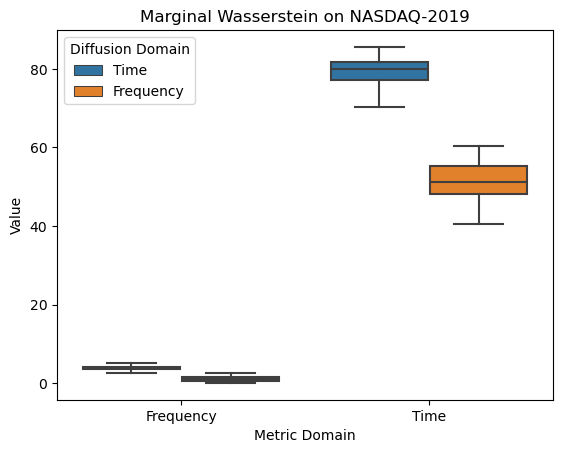

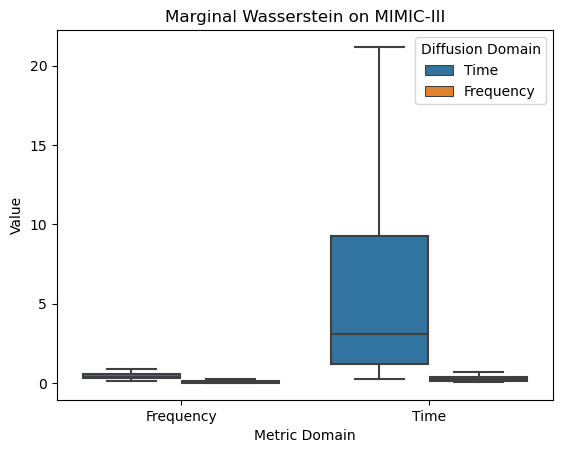

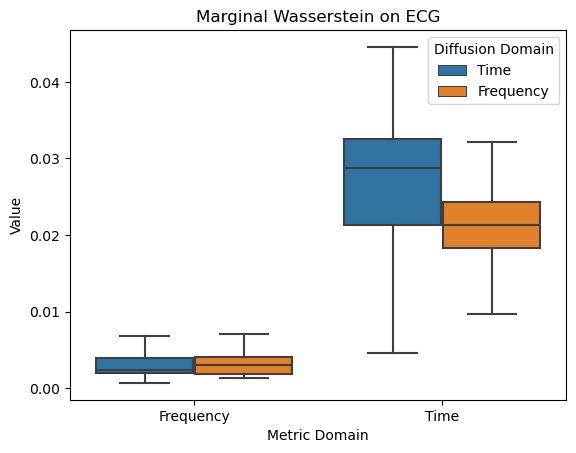

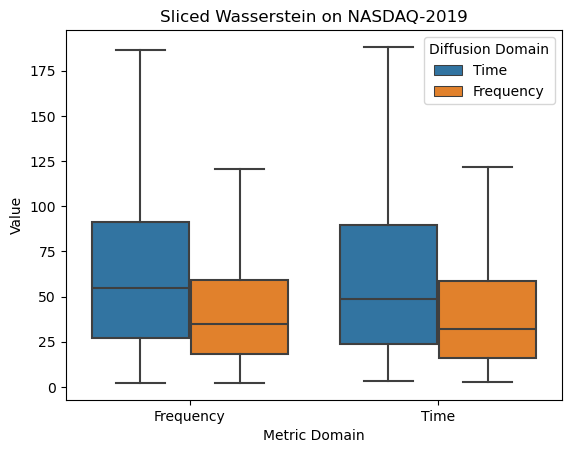

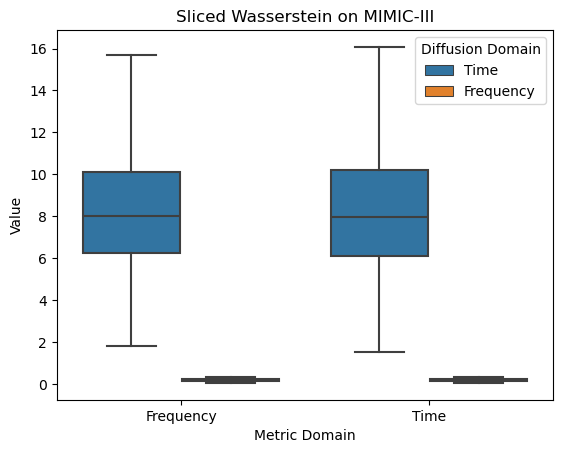

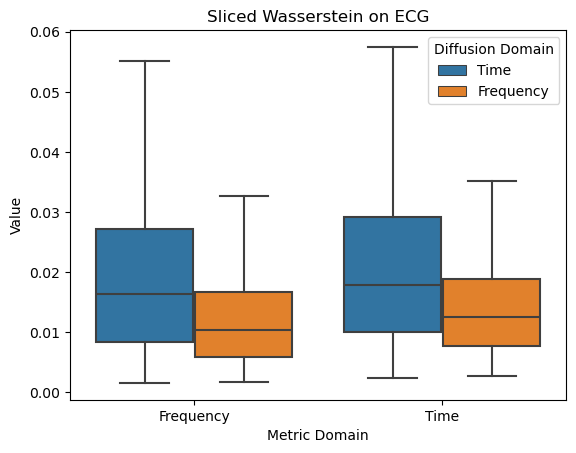

In [14]:
for metric in df.Metric.unique():
    for dataset in df.Dataset.unique():
            ax = sns.boxplot(data=df[(df.Metric == metric) & (df.Dataset == dataset)], 
                        x="Metric Domain",
                        y="Value", 
                        hue="Diffusion Domain",
                        hue_order=["Time", "Frequency"],
                        showfliers = False,
                        )
            plt.title(f"{metric} on {dataset}")
            plt.show()

In [35]:
spectral_density_list = []
for run in run_list:
    data = {}
    with open(runs_dir / f"{run}/train_config.yaml", "r") as f:
        config = safe_load(f)
        data["Dataset"] = infer_dataset(config["datamodule"]["_target_"])
        data["Diffusion Domain"] = infer_diffusion_domain(config["fourier_transform"])
    with open(runs_dir / f"{run}/results.yaml", "r") as f:
        results = safe_load(f)
        data["Specral Density"] = calculate_spectral_density(results["freq_marginal_wasserstein_all"], data["Dataset"])
        spectral_density_list.append(data)
spectral_density_list    

[{'Dataset': 'NASDAQ-2019',
  'Diffusion Domain': 'Frequency',
  'Specral Density': [809.6719970703125,
   63.1424674987793,
   41.79159164428711,
   22.867511749267578,
   20.1268367767334,
   17.066654205322266,
   15.951713562011719,
   14.6133394241333,
   13.042460441589355,
   9.046859741210938,
   10.254725456237793,
   8.590145111083984,
   10.040194511413574,
   9.318804740905762,
   6.75900411605835,
   6.458128452301025,
   7.269366264343262,
   7.896665096282959,
   6.261915683746338,
   5.675816535949707,
   5.243130683898926,
   4.324759483337402,
   4.1959943771362305,
   3.860518217086792,
   3.261601209640503,
   4.5958476066589355,
   4.237555027008057,
   2.476475477218628,
   2.710827589035034,
   2.961428642272949,
   1.9427402019500732,
   2.843383312225342,
   3.726487398147583,
   3.09312105178833,
   3.1508617401123047,
   1.9665400981903076,
   2.9506115913391113,
   3.005502223968506,
   2.503760814666748,
   2.960820436477661,
   2.429760456085205,
   3.0907

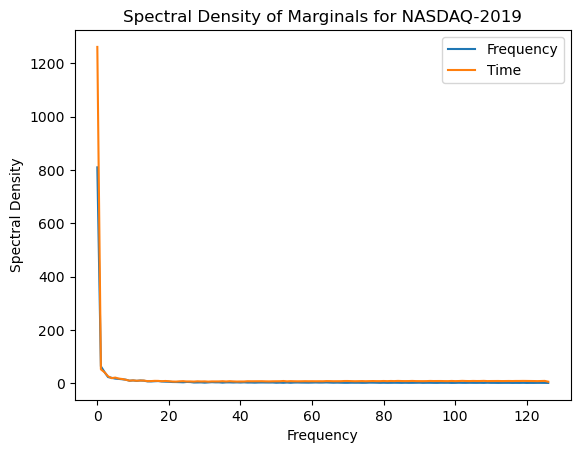

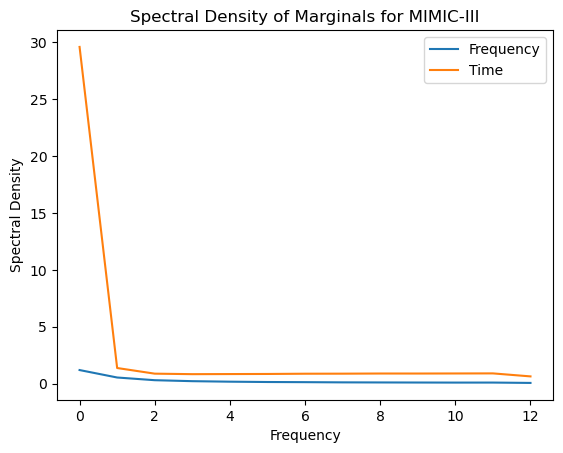

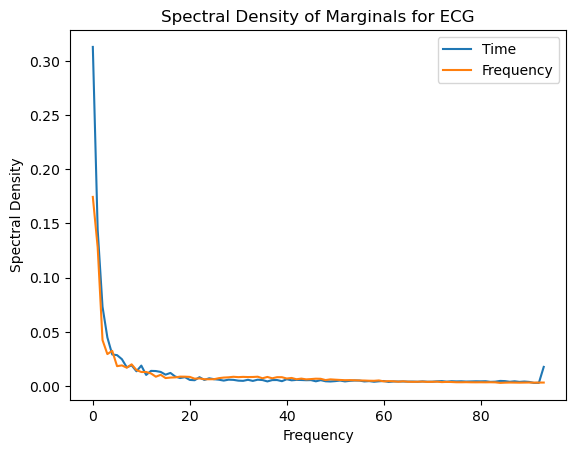

In [36]:
# For each dataset, plot the spectral density of the marginals
for dataset in df.Dataset.unique():
    fig, ax = plt.subplots()
    for data in spectral_density_list:
        if data["Dataset"] == dataset:
            ax.plot(data["Specral Density"], label=data["Diffusion Domain"])
    ax.set_title(f"Spectral Density of Marginals for {dataset}")
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Spectral Density")
    ax.legend()
    plt.show()